# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.18 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        #print(actions)
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        #print(rewards)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: 0.04500000085681677


When finished, you can close the environment.

In [ ]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [5]:
%load_ext autoreload
%autoreload 2
import numpy as np
from ddpg_agent import Agent,ReplayBuffer
from collections import deque
import random
import torch
from collections import deque
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [6]:
def ddpg(n_episodes=4000):
    scores_deque = deque(maxlen=100)
    scores_ep  = []
    start=time.time()
    max_score = -np.Inf
    agents = [] 
    agent_scores =deque(maxlen=100)
    
    env_info = env.reset(train_mode=True)[brain_name] # reset the environment
    state = env_info.vector_observations
    
    #use a shared replay buffer
    BUFFER_SIZE = int(1e5)  # replay buffer size
    BATCH_SIZE = 128        # minibatch size
    SharedReplay = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed=0)
    
    #state space is two agent space combined 
    state_size = state.shape[1] +1 # add another state space to flag out player
    for i in range(num_agents):
        agents.append(Agent(state_size, action_size, random_seed=0,SharedReplayBuffer=SharedReplay))
    
    #make them sharing critic actor and memory
    agents[1].critic_local = agents[0].critic_local
    agents[1].critic_target = agents[0].critic_target
    agents[1].critic_optimizer = agents[0].critic_optimizer

    agents[1].actor_local = agents[0].actor_local
    agents[1].actor_target = agents[0].actor_target
    agents[1].actor_optimizer = agents[0].actor_optimizer
        
    print('instantiated {} agents'.format(num_agents))   
    perform_episode_count = 0 
    completion_episode = 0
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations            # get the current state
        state = [np.append(state[0],[1]).reshape((1,state_size)), np.append(state[1],[-1]).reshape((1,state_size))]
        for agent in agents:
            agent.reset()
            
        scores_in_episode =np.zeros(num_agents)
        score = 0
        timestep = time.time()
        #print('start episode {} timestep iteration'.format(i_episode))
        t=0
        while True:
        #for t in range(max_t):
            #print(state)
            action = np.array([agents[i].act(state[i])[0] for i in range(num_agents)])
            #print(action)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations   # get the next state
            next_state = [np.append(next_state[0],[1]).reshape((1,state_size)), np.append(next_state[1],[-1]).reshape((1,state_size))]
            reward = env_info.rewards                   # get the reward
            done = env_info.local_done                  # see if episode has finished
            #next_state, reward, done, _ = env.step(action)
            for i in range(num_agents):
                #print("agent ",i," take step")
                agents[i].step(state[i], action[i], reward[i], next_state[i], done[i])
                
            state = next_state
            scores_in_episode += reward
            if np.any(done):
                break
           
            t=t+1
            #if t % 500 ==0:
            #    print(t)
            
        agent_scores.append(scores_in_episode)
        score = np.max(scores_in_episode) #take the max
        scores_deque.append(score)
        scores_ep.append(np.mean(scores_deque))
        
        if i_episode % 100 == 0:
            torch.save(agents[0].actor_local.state_dict(), 'checkpoint_actor0.pth')
            torch.save(agents[0].critic_local.state_dict(), 'checkpoint_critic0.pth')
            torch.save(agents[1].actor_local.state_dict(), 'checkpoint_actor1.pth')
            torch.save(agents[1].critic_local.state_dict(), 'checkpoint_critic1.pth')            
            
            print('{} timestep in Episode {}\t Mean Score for Agent 1: {:.3f}, Mean Score for Agent 2: {:.3f}, Mean Score of both Agents: {:.3f}'\
                  .format(t,i_episode, np.mean(agent_scores[0]), np.mean(agent_scores[1]), np.mean(scores_deque)))
            end = time.time()
            print("Time used {} as at episode {}".format(end-start,i_episode))
        if np.mean(scores_deque)>0.5:
            perform_episode_count+=1
            torch.save(agents[0].actor_local.state_dict(), 'checkpoint_actor0.pth')
            torch.save(agents[0].critic_local.state_dict(), 'checkpoint_critic0.pth')
            torch.save(agents[1].actor_local.state_dict(), 'checkpoint_actor1.pth')
            torch.save(agents[1].critic_local.state_dict(), 'checkpoint_critic1.pth')
            if perform_episode_count==100:
                completion_episode = i_episode -perform_episode_count
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(completion_episode, np.mean(scores_deque)))
                break
        if i_episode >1500:
            break
            
    end = time.time()
    print("Time used {}".format(end-start))
    return scores_ep,completion_episode

scores_ep,completion_episode = ddpg()



cpu
cpu
instantiated 2 agents
14 timestep in Episode 100	 Mean Score for Agent 1: -0.005, Mean Score for Agent 2: -0.005, Mean Score of both Agents: 0.000
Time used 41.60310769081116 as at episode 100
13 timestep in Episode 200	 Mean Score for Agent 1: -0.005, Mean Score for Agent 2: -0.005, Mean Score of both Agents: 0.003
Time used 83.22573900222778 as at episode 200
13 timestep in Episode 300	 Mean Score for Agent 1: -0.005, Mean Score for Agent 2: 0.095, Mean Score of both Agents: 0.053
Time used 156.9398934841156 as at episode 300
30 timestep in Episode 400	 Mean Score for Agent 1: -0.005, Mean Score for Agent 2: -0.005, Mean Score of both Agents: 0.089
Time used 259.64864325523376 as at episode 400
29 timestep in Episode 500	 Mean Score for Agent 1: 0.045, Mean Score for Agent 2: 0.045, Mean Score of both Agents: 0.143
Time used 406.8850164413452 as at episode 500
29 timestep in Episode 600	 Mean Score for Agent 1: 0.045, Mean Score for Agent 2: 0.045, Mean Score of both Agents: 

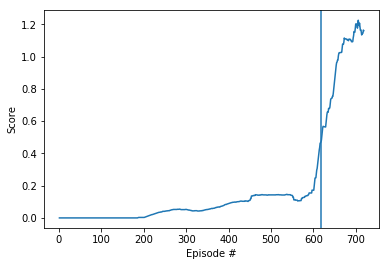

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_ep)+1), scores_ep)
plt.axvline(x=completion_episode)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()